<a href="https://colab.research.google.com/github/liron7722/AI-Generated-Text-Detector/blob/Production/AI_Generated_Text_Detector.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

אסתר: הוספתי עוד עמודה של מספר המשפטים בטקסט, אחרי שראיתי שיש ערכים חריגים באורכי מילים בטקסטים מגונרטים.

לדעתי כדאי לשמור DF חדש

לדיון- האם לעשות משהו עם הערכים החריגים של אורכי מילים, ואם כן - מה.

NGRAMS אורן אמר בפגישה האחרונה שכדאי לעשות צירופים של 10 מילים



todo clusteriung and then the distance from the cluster
PCA
increace to 2-6 ngrams 1k-10k
to look on the words from ngrams and see they are informative

histogram on POS (not needed)

see what feature helped more and what helped less

next phase is text embaddings

# TO-DO




Done:
* GH Proejct created
* Getting larger Dataset
* EDA Start
* Do comperistion between Generated and not Generated Words\Sentences count
* Use n-grams - Combination of group of words
* Complete EDA Visualization (Ester)

Do not do
- do lower case manipulation on the text


Next Steps
* Balance the data by multiple smaller class by 3 (Ester)
* Complete Feaures (Liron)
* Create Models (Ester)


Optional (Future)
- make graph of our etl or models


## Deck Remarks

Inital Deck remarks

* מספרי כרטסיטיות
* גופן
* יותר מידי זמן על הרקע
* יותר הסברים על הפיצרים
* לא להתרכז ב f1
* להגדיל כתב ולנצל שטח פתוח
* להסביר על הטיפול באיזון של המידע
* שיהיה קוד שנהיה גאים בו ונפגין יכולות
* עמוד פתיחה עם תמונה רלוונטית
* בהצגה סופית להסביר טכני
* להראות דוגמא של טקסט ממכונה והלראות שזה לא פשוט לנחש
* שיהיה בשר תכנותי, לשקול לכתוב מודל משלנו
* דברים שעושים במצגות ברמה גבוהה
* מוסיפים איזה אייקון לכל שקופית מספר פעמים ומבקשים מהקהל להגיד כמה היה בסוף המצגת
* לפני ששואלים שאלה אותנו אז נבקש להגיד מילת מפתח כמו השם של הקבוצה שלנו או משהו מהותי למצגת שלנו
בסוף כל המצגות נראה שאמרו את המיל מפתח שלנו הכי הרבה
בגרף של המילים
* לשאול את הכיתה בהתחלה כמה מהמצגת שלנו נוצרה ע"י LLM








###### KaggleCompetition

In [ ]:
# KaggleCompetition = 'https://www.kaggle.com/competitions/llm-detect-ai-generated-text/overview'



```
File and Field Information

{test|train}_essays.csv
id - A unique identifier for each essay.
prompt_id - Identifies the p\rompt the essay was written in response to.
text - The essay text itself.
generated - Whether the essay was written by a student (0) or generated by an LLM (1).
This field is the target and is not present in test_essays.csv.

train_prompts.csv - Essays were written in response to information in these fields.
prompt_id - A unique identifier for each prompt.
prompt_name - The title of the prompt.
instructions - The instructions given to students.
source_text - The text of the article(s) the essays were written in response to, in Markdown format.
Significant paragraphs are enumerated by a numeral preceding the paragraph on the same line, as in 0 Paragraph one.
Paragraph two.. Essays sometimes refer to a paragraph by its numeral.
Each article is preceded with its title in a heading, like # Title.
When an author is indicated, their name will be given in the title after by.
Not all articles have authors indicated. An article may have subheadings indicated like ## Subheading.

sample_submission.csv - A submission file in the correct format. See the Evaluation page for details.
```



# CFG
class for variables

In [1]:
class CFG:
  verbose = 0  # Verbosity

  wandb = True  # Weights & Biases logging
  competition = 'llm-detect-ai-generated-text'  # Competition name
  _wandb_kernel = 'awsaf49'  # WandB kernel
  comment = 'DebertaV3-MaxSeq_200-ext_s-torch'  # Comment description

  preset = "deberta_v3_base_en"  # Name of pretrained models
  sequence_length = 200  # Input sequence length

  device = 'TPU'  # Device

  seed = 42  # Random seed

  num_folds = 5  # Total folds
  selected_folds = [0, 1]  # Folds to train on

  epochs = 3 # Training epochs
  batch_size = 3  # Batch size
  drop_remainder = True  # Drop incomplete batches
  cache = True # Caches data after one iteration, use only with `TPU` to avoid OOM

  scheduler = 'cosine'  # Learning rate scheduler

  class_names = ["real", "fake"]  # Class names [A, B, C, D, E]
  num_classes = len(class_names)  # Number of classes
  class_labels = list(range(num_classes))  # Class labels [0, 1, 2, 3, 4]
  label2name = dict(zip(class_labels, class_names))  # Label to class name mapping
  name2label = {v: k for k, v in label2name.items()}  # Class name to label mapping

config = CFG()

# Importing Libraries

In [2]:
# General
import numpy as np
import pandas as pd
import io
import sys
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import string
import re
import nltk
import logging
import wandb
import os
import joblib
import pyarrow as pa

from google.colab import userdata
from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from nltk.util import ngrams
#from nltk.util import ngram_freq
from nltk.translate import nist_score
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer

# Pre Models Training
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE

# Models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier


cmap = mpl.colormaps.get_cmap('coolwarm')


import warnings
warnings.filterwarnings('ignore')
for pkg in ['omw-1.4', 'punkt', 'punkt_tab', 'averaged_perceptron_tagger', 'stopwords', 'averaged_perceptron_tagger_eng']:
  nltk.download(pkg, quiet=True)

if config.wandb:
  wandb.login(key=userdata.get('WANDB_API_KEY'))

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


# Loading Data

## raw data

In [3]:
train_essays = pd.read_csv('https://raw.githubusercontent.com/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/train_essays.csv')
train_prompts = pd.read_csv('https://raw.githubusercontent.com/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/train_prompts.csv')
train_essays.head()

,version https://git-lfs.github.com/spec/v1
0,oid sha256:9c69738ab129c335ef8b0a5ac14330fcfc5...
1,size 4399547


In [ ]:
text_df = pd.read_parquet('https://github.com/liron7722/AI-Generated-Text-Detector/raw/refs/heads/Production/data/train_essays.parquet')
text_df

,id,prompt_id,text,generated
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1
...,...,...,...,...
165762,e_163n6u2y,103,We were meant to do this together. That was th...,0
165763,e_a8z8z5hc,103,Title: Emerald Smoke\nWord Count: 701\nThe onc...,1
165764,e_qltzexs2,103,"In a sleepy town nestled amidst rolling hills,...",1
165765,e_n1p85skh,103,"In the bustling city of Elysium, nestled amids...",1


## after basic EDA

In [4]:
# data after basic EDA
text_df=pd.read_csv('https://media.githubusercontent.com/media/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/text_df_2024_11_14.csv')

## NGrams_data

In [5]:
NGrams_data = pd.read_csv('https://media.githubusercontent.com/media/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/tfidf_ngram_features.csv')

# EDA

In [ ]:
text_df['text'][165763]

"Title: Emerald Smoke\nWord Count: 701\nThe once-thriving city lay in ruins, a chaotic mix of crumbling buildings and debris strewn across the streets. The air was heavy with smoke, a constant reminder of the devastation that had befallen humanity. Amidst the chaos, a small group of soldiers trudged through the desolate landscape, their uniforms tattered and faces etched with exhaustion.\nSergeant Jameson, the group leader, led them with a grim determination. His squad consisted of Private Reynolds, Corporal Jensen, and Specialist Taylor, each silently contemplating the horrors they had witnessed. They had grown used to the distorted world they found themselves in, where scarcity defined survival, and fear gripped every waking moment.\nIt was during one of their routine patrols that Jensen noticed something glimmering near a collapsed building. Intrigued, he urged his comrades towards it. Beneath the rubble, they discovered a partially intact box, its contents unscathed by time. The so

In [ ]:
text_df['generated'].value_counts()

,count
generated,
1,129522
0,36245


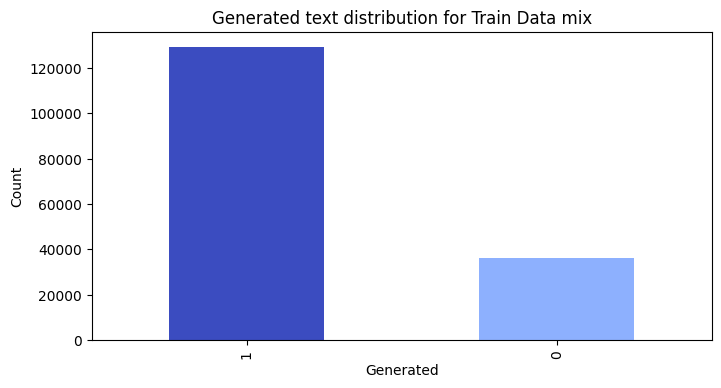

In [ ]:
# Show distribution of generated text using a bar plot
plt.figure(figsize=(8, 4))
text_df.generated.value_counts().plot.bar(color=[cmap(0.0), cmap(0.25), cmap(0.65), cmap(0.9), cmap(1.0)])
plt.xlabel("Generated")
plt.ylabel("Count")
plt.title("Generated text distribution for Train Data mix")
plt.show()

In [ ]:
counts = text_df[['prompt_id','generated']].value_counts().sort_index()

In [ ]:
counts

prompt_id  generated
0          0             3320
           1            10525
1          0             3232
           1            10629
2          0             2132
           1            10542
3          0             1974
           1             9828
4          0             2319
           1            11162
5          0             2657
           1            11190
6          0             2324
           1            11524
7          0             2534
           1             5850
8          0             1895
           1             5663
9          0             1969
           1             5190
10         0             1976
           1             6498
11         0             1940
           1             5713
12         0             1860
           1             6165
13         0             1804
           1             5437
14         0             1353
           1             4484
100        0              970
           1             3095
102        0              975
           1             2971
103        0             1011
           1             3056
Name: count, dtype: int64

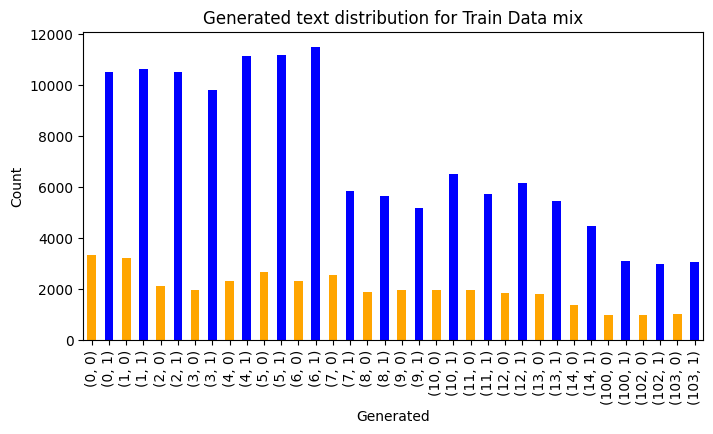

In [ ]:
# Show distribution of generated text using a bar plot
plt.figure(figsize=(8, 4))
#text_df[['prompt_id','generated']].value_counts().sort_index().plot.bar()
counts.plot(kind='bar', color=['orange' if i[1] == 0 else 'blue' for i in counts.index])
plt.xlabel("Generated")
plt.ylabel("Count")
plt.title("Generated text distribution for Train Data mix")
plt.show()

## Removing Duplicate Rows

In [ ]:
# Removing Duplicate Rows
text_df = text_df.drop_duplicates(subset=['text'])
text_df.reset_index(drop=True, inplace=True)

In [ ]:
# chech for missing data
text_df.isnull().sum()
#text_df.count()

,0
id,0
prompt_id,0
text,0
generated,0


## Counts and Lenght:
### Start by checking how long the reviews are


*   Character count
*   Word count
*   Mean word length
*   Mean sentence length
*   Sentence count

In [ ]:
lenght = len(text_df['text'][0])
print(f'Character Count of a sample assay: {lenght}')

Length of a sample assay: 1789


In [ ]:
text_df['Character_Count'] = text_df['text'].str.len()
text_df.head(10)

,id,prompt_id,text,generated,Character_Count
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437


In [ ]:
#Word Count: Number of words in an assay
word_count = text_df['text'][0].split()
print(f'Word count in a sample assay: {len(word_count)}')

Word count in a sample assay: 316


In [ ]:
def word_count(text):
    text_list = text.split()
    return len(text_list)

In [ ]:
text_df['Word_count'] = text_df['text'].apply(word_count)
text_df.head(10)

,id,prompt_id,text,generated,Character_Count,Word_count
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049,364
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615,614
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971,515
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203,410
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437,449


In [ ]:
# Mean word length: Average length of words
text_df['Average_word_length'] = text_df['text'].map(lambda rev: np.mean([len(word) for word in rev.split()]))
#text_df['total_word_length'] = text_df['text'].map(lambda rev: np.sum([len(word) for word in rev.split()]))
text_df.head(10)

,id,prompt_id,text,generated,Character_Count,Word_count,Average_word_length
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049,364,4.620879
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615,614,4.858306
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971,515,4.763107
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203,410,4.365854
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437,449,4.418708


In [ ]:
text_df['Sentence_count'] = text_df['text'].map(lambda rev: len(tokenize.sent_tokenize(rev)))
text_df.head()

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,pos_counts,keywords,Sentence_count
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,84.238095,88.250000,174,139,0.270650,0.432759,<FreqDist with 28 samples and 367 outcomes>,"[array(['car', 'help', 'cars', 'make', 'time']...",20
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,174.000000,183.157895,320,251,0.135949,0.448521,<FreqDist with 31 samples and 664 outcomes>,"[array(['help', 'cars', 'make', 'time', 'like'...",19
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,169.461538,276.000000,272,158,0.131495,0.405460,<FreqDist with 36 samples and 437 outcomes>,"[array(['car', 'make', 'time', 'people'], dtyp...",8
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,61.160000,60.960000,158,104,0.077507,0.333694,<FreqDist with 27 samples and 311 outcomes>,"[array(['car', 'cars', 'time', 'people', 'scho...",25
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,98.562500,92.529412,166,153,0.247581,0.428763,<FreqDist with 30 samples and 336 outcomes>,"[array(['car', 'time', 'like', 'just', 'people...",17


In [ ]:
# Mean sentence length: Average length of the sentences in the assay, split by dot
text_df['Average_sentence_length_split'] = text_df['text'].map(lambda rev: np.mean([len(sent) for sent in rev.split('.')]))
#text_df['total_sentence_length_split'] = text_df['text'].map(lambda rev: np.sum([len(sent) for sent in rev.split('.')]))
text_df.head(10)

,id,prompt_id,text,generated,Character_Count,Word_count,Average_word_length,Sentence_count,Average_sentence_length_split
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,20,84.238095
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,19,174.000000
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,8,169.461538
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,25,61.160000
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,17,98.562500
5,e_mgv97k7z,0,Limiting car usage will have many advantages. ...,0,2049,364,4.620879,20,77.846154
6,e_3zjz1v5b,0,### The Advantages of Limiting Car Usage\n\nCa...,1,3615,614,4.858306,36,96.729730
7,e_1m6o7oy4,0,"Cars have been around since the early 1900's, ...",0,2971,515,4.763107,27,101.482759
8,e_cl5fygab,0,Cars have been an important part of our societ...,1,2203,410,4.365854,25,75.000000
9,e_d3pyqm0y,0,Think about a country without cars. You might ...,1,2437,449,4.418708,25,115.095238


In [ ]:
# Mean sentence length: Average length of the sentences in the assay, split by tokenize
tmp = pd.DataFrame()
tmp['tokens'] = text_df['text'].map(lambda rev: [len(sent) for sent in tokenize.sent_tokenize(rev)])
tmp.head(10)

In [ ]:
tmp.head(10)

,tokens
0,"[70, 237, 46, 31, 138, 87, 49, 80, 116, 62, 10..."
1,"[220, 102, 154, 144, 189, 336, 94, 229, 88, 11..."
2,"[190, 49, 767, 442, 180, 289, 209, 82]"
3,"[74, 56, 52, 51, 111, 107, 64, 29, 80, 73, 50,..."
4,"[58, 46, 70, 41, 39, 52, 139, 98, 108, 29, 64,..."
5,"[45, 87, 78, 107, 56, 68, 98, 37, 122, 237, 10..."
6,"[136, 74, 87, 46, 91, 82, 86, 44, 98, 68, 58, ..."
7,"[89, 136, 97, 99, 47, 48, 121, 60, 97, 198, 10..."
8,"[132, 87, 85, 78, 70, 50, 40, 185, 91, 81, 75,..."
9,"[35, 22, 2, 23, 17, 211, 52, 138, 206, 168, 16..."


In [ ]:
text_df['Average_sentence_length_tokenize'] = tmp['tokens'].map(lambda rev: np.mean(rev))
#text_df['total_sentence_length_tokenize'] = tmp['tokens'].map(lambda rev: np.sum(rev))
text_df.head()

,id,prompt_id,text,generated,Character_Count,Word_count,Average_word_length,Sentence_count,Average_sentence_length_split,Average_sentence_length_tokenize
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,20,84.238095,88.250000
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,19,174.000000,183.157895
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,8,169.461538,276.000000
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,25,61.160000,60.960000
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,17,98.562500,92.529412


### save to csv with new column

In [ ]:
text_df.to_csv('./text_df_2024_11_25_basic_EDA.csv', index=False, escapechar='\\')

### explore new features

In [ ]:
text_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 158294 entries, 0 to 158293
Data columns (total 16 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   id                             158294 non-null  object 
 1   prompt_id                      158294 non-null  int64  
 2   text                           158294 non-null  object 
 3   generated                      158294 non-null  int64  
 4   Length                         158294 non-null  int64  
 5   Word_count                     158294 non-null  int64  
 6   mean_word_length               158294 non-null  float64
 7   mean_sentence_length_split     158294 non-null  float64
 8   mean_sentence_length_tokenize  158294 non-null  float64
 9   unique_word_count              158294 non-null  int64  
 10  stopword_count                 158294 non-null  int64  
 11  polarity                       158294 non-null  float64
 12  subjectivity                  

In [ ]:
text_df.describe()

,prompt_id,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,Sentence_count
count,158294.000000,158294.000000,158294.000000,158294.00000,158294.000000,158294.000000,158294.000000,158294.000000,158294.000000,158294.000000,158294.000000,158294.000000
mean,13.197537,0.771166,2280.312362,396.99295,4.732193,123.298344,130.298706,201.046401,173.222826,0.158319,0.498099,19.794263
std,25.741263,0.420083,1162.343819,194.73148,7.105493,118.804702,130.769269,91.515071,89.487453,0.113373,0.090011,12.311568
min,0.000000,0.000000,256.000000,1.00000,1.000000,0.040389,2.426752,1.000000,0.000000,-1.000000,0.000000,1.000000
25%,3.000000,1.000000,1445.000000,261.00000,4.325301,91.545455,94.653846,139.000000,113.000000,0.088225,0.443468,12.000000
50%,6.000000,1.000000,2066.000000,362.00000,4.608808,110.770330,115.347826,186.000000,156.000000,0.151208,0.496143,18.000000
75%,10.000000,1.000000,2875.750000,493.00000,4.970654,132.416667,139.357143,246.000000,212.000000,0.223565,0.551500,25.000000
max,103.000000,1.000000,36191.000000,5132.00000,2590.000000,7884.000000,12967.500000,1801.000000,1781.000000,1.000000,1.000000,1570.000000


In [ ]:
# as we can see there are outliares at mean_word_length col. there is no word that have 2K+ chars.
#lets examine mean_word_length col:
text_df.sort_values(by='mean_word_length', ascending=False, inplace=True)

In [ ]:
text_df.head()

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,pos_counts,keywords,Sentence_count
50113,e_ua4nmmew,6,Venus is our closest planet to us besides Mars...,1,2919,139,19.978417,485.666667,485.000000,116,65,0.105316,0.418069,<FreqDist with 27 samples and 1452 outcomes>,"[array(['help', 'like', 'just'], dtype='<U8')]",6
80558,e_4992br2r,4,True Automobiles\n\nI can imagine a future wro...,1,1594,77,19.675325,226.857143,317.800000,73,15,0.308036,0.543304,<FreqDist with 18 samples and 90 outcomes>,"[array(['cars'], dtype='<U8')]",5
47036,e_49wxcd12,6,"In this passaage ""The Challenge Of Exploring V...",1,1478,72,19.541667,492.000000,492.000000,61,21,0.393889,0.602778,<FreqDist with 24 samples and 84 outcomes>,"[array(['like'], dtype='<U8')]",3
55008,e_6og1dz2i,5,Use of FACS in the Classroom\n\nIsn't it just ...,1,1672,83,19.144578,333.600000,277.833333,70,27,0.004630,0.580556,<FreqDist with 21 samples and 91 outcomes>,"[array(['like', 'just', 'school'], dtype='<U8')]",6
77449,e_0beesm9q,4,It is true that there will be a lot of beneift...,1,981,49,19.040816,490.000000,244.500000,45,22,-0.137500,0.675000,<FreqDist with 19 samples and 749 outcomes>,"[array(['car'], dtype='<U8')]",4


In [ ]:
text_df.text.values[90]

'Thousands of people aroound the world drive cars everyday to get where they need to go such as school,work,and even just to go shopping but thats starting\xa0 to change around the world. Countries such as Bogata,Germany,and the United States\xa0 are starting\xa0\ufeffto cut back\xa0\ufeffon\xa0\ufeffcar-usage\xa0\ufeffto help the enviroment\ufeff and eower greenhouoe gas emissions\xa0\ufeff.\n\nBogota,Colombia has a program that promotes limiting car usage and it has worked\xa0\ufeffvery weal\xa0\ufefffor them\xa0\ufeffso far\ufeff. They have a day\xa0\ufeffwhere\xa0\ufeffcars are not allowed\ufeff\ufeff\ufeffto be on\ufeff\ufeff\ufeffthe\ufeff\ufeff\ufeffstreets\ufeff\ufeff\ufeff\ufeffAtA total of almost four million\xa0\ufeffcolombians hiked,biked,skated,or took buses to work or where they needed to go for the day. This\xa0\ufeffday without cars\ufeff\ufeffhas been going\xa0\ufeffon\ufeff\ufeff\ufefffor three years\ufeff\ufeffand\xa0\ufeffhas\ufeff\ufeff\ufeffbeen helping\xa0\ufeff\

In [ ]:
#lets handle them:
text_df = text_df[text_df['mean_word_length'] < 20]

In [ ]:
text_df

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,pos_counts,keywords,Sentence_count
50113,e_ua4nmmew,6,Venus is our closest planet to us besides Mars...,1,2919,139,19.978417,485.666667,485.000000,116,65,0.105316,0.418069,<FreqDist with 27 samples and 1452 outcomes>,"[array(['help', 'like', 'just'], dtype='<U8')]",6
80558,e_4992br2r,4,True Automobiles\n\nI can imagine a future wro...,1,1594,77,19.675325,226.857143,317.800000,73,15,0.308036,0.543304,<FreqDist with 18 samples and 90 outcomes>,"[array(['cars'], dtype='<U8')]",5
47036,e_49wxcd12,6,"In this passaage ""The Challenge Of Exploring V...",1,1478,72,19.541667,492.000000,492.000000,61,21,0.393889,0.602778,<FreqDist with 24 samples and 84 outcomes>,"[array(['like'], dtype='<U8')]",3
55008,e_6og1dz2i,5,Use of FACS in the Classroom\n\nIsn't it just ...,1,1672,83,19.144578,333.600000,277.833333,70,27,0.004630,0.580556,<FreqDist with 21 samples and 91 outcomes>,"[array(['like', 'just', 'school'], dtype='<U8')]",6
77449,e_0beesm9q,4,It is true that there will be a lot of beneift...,1,981,49,19.040816,490.000000,244.500000,45,22,-0.137500,0.675000,<FreqDist with 19 samples and 749 outcomes>,"[array(['car'], dtype='<U8')]",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53242,e_q67mf00m,5,_ _ _ _ _ _ _ _ _ _ _ _ __ _ _ _ _ _ _ _ _ _ _...,1,3072,1536,1.000651,3072.000000,3072.000000,2,0,0.000000,0.000000,<FreqDist with 3 samples and 1536 outcomes>,"[array([], dtype='<U8')]",1
1994,e_k1nm7mcc,0,_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ ...,1,3071,1536,1.000000,3071.000000,3071.000000,1,0,0.000000,0.000000,<FreqDist with 3 samples and 1536 outcomes>,"[array([], dtype='<U8')]",1
7641,e_iqqa5p29,0,_\n\n_\n\n_\n\n_\n\n_\n\n_\n\n_\n\n_\n\n_\n\n_...,1,1534,514,1.000000,1534.000000,1534.000000,1,0,0.000000,0.000000,<FreqDist with 3 samples and 514 outcomes>,"[array([], dtype='<U8')]",1
1054,e_fjbij35g,0,_ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _ _...,1,3070,1535,1.000000,3070.000000,3070.000000,1,0,0.000000,0.000000,<FreqDist with 3 samples and 1535 outcomes>,"[array([], dtype='<U8')]",1


In [ ]:
text_df.sort_values(by='Sentence_count', ascending=False, inplace=True)

In [ ]:
text_df.head(20)

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,pos_counts,keywords,Sentence_count
119144,e_um8zzrgc,9,"Dear Principal,\n\nI believe that you should k...",1,5381,1977,1.720789,2.434588,2.426752,301,184,0.126945,0.436185,<FreqDist with 32 samples and 2014 outcomes>,"[array(['help', 'make', 'time', 'like', 'just'...",1570
76751,e_29o5stm1,4,The road to the future is here. The future is ...,1,8234,1647,4.000000,19.587500,19.587500,20,429,0.007000,0.129750,<FreqDist with 14 samples and 2046 outcomes>,"[array(['car', 'people'], dtype='<U8')]",400
60038,e_gjjh5z2t,5,I think this kind of techno is a great way to ...,1,3828,619,2.114701,8.644836,3.868687,80,112,0.455870,0.612609,<FreqDist with 20 samples and 639 outcomes>,"[array(['help', 'people'], dtype='<U8')]",396
70711,e_ul0x81iz,2,So you believe that the face on Mars was creat...,1,4555,632,2.202532,10.926702,4.298429,65,156,0.114286,0.401190,<FreqDist with 20 samples and 653 outcomes>,"[array(['just'], dtype='<U8')]",382
76638,e_3s0cpbhm,4,I think that the smart cars would be a great i...,1,4500,586,2.293515,13.805921,7.795987,126,90,0.183163,0.481803,<FreqDist with 24 samples and 605 outcomes>,"[array(['car', 'cars', 'make', 'like', 'people...",299
33611,e_xp1mo1ep,3,"Do you wanna take care of horses,cows,and mule...",1,8076,1775,3.550423,28.914815,28.804428,38,552,0.136364,0.454545,<FreqDist with 15 samples and 2050 outcomes>,"[array(['help'], dtype='<U8')]",271
73181,e_e3oayda0,2,Many people think that the face ia real. But i...,1,8201,1543,4.314323,30.914397,30.906615,24,519,0.102264,0.404134,<FreqDist with 13 samples and 1799 outcomes>,"[array(['people'], dtype='<U8')]",257
148955,e_tusmk83v,100,The approach and thought process underlying th...,0,36191,5132,6.051832,139.824903,142.051383,1801,1781,0.119700,0.471593,<FreqDist with 37 samples and 5813 outcomes>,"[array(['help', 'make', 'time', 'like', 'just'...",253
75576,e_nak687sn,2,In 1976 NASA found an interestinng object on M...,1,8063,1706,3.725674,34.524229,34.515419,44,845,0.180435,0.636522,<FreqDist with 15 samples and 1932 outcomes>,"[array(['like', 'just', 'people'], dtype='<U8')]",227
72162,e_jvopu9xw,2,"In 1976, the Viking 1 took a phohto of Mars. T...",1,6797,1497,3.520374,30.041096,29.899543,34,714,-0.093651,0.444444,<FreqDist with 14 samples and 1717 outcomes>,"[array([], dtype='<U8')]",219


In [ ]:
text_df.text.values[10]

'The librarian looked up and smiled when he entered. Its Saturday and he\'s in the library again.\nLee walked in and looked around at his world. A beautiful world that people with a passion had built. And he was all alone again. Of course there\'s that weird guy that comes in to read the newspaper, he\'d seen him over the weeks and thought the paper is less than a buck to have delivered, why drive here cheapskate. Anyway, what was on the menu today.\nRoaming up and down the isles looking at the funny numbering system 101.001 -500 to the left, 101.501-1000 on the right. Its nice to be able to understand what you\'re looking for. He liked this library, it still had an old fashioned card catologue.\nScience. It makes sense. \'What subject though\'. Flipping cards over and over \'Newton?\' Can I understand this? Sure if they could figure this stuff out 300 years ago, i should be able to understand it now. A scrap of paper with some obscure numbers on it and off he goes.\n\'I\'ve got all da

## Visualize - boxplot and KDE

In [ ]:
features = text_df.columns.tolist()[4:13]
features.append('Sentence_count')
features

['Length',
 'Word_count',
 'mean_word_length',
 'mean_sentence_length_split',
 'mean_sentence_length_tokenize',
 'unique_word_count',
 'stopword_count',
 'polarity',
 'subjectivity',
 'Sentence_count']

In [ ]:
# עקומת KDE ממחישה את התפלגות המידע באמצעות עקומת צפיפות רציפה
def visualize(data,col,hue_col):

    plt.subplot(1,2,1)
    sns.boxplot(data=data, y=data[col], hue=data[hue_col])
    plt.ylabel(col, labelpad=12.5)

    plt.subplot(1,2,2)
    sns.kdeplot(data=data, x=col, hue=hue_col)
    plt.legend(data[hue_col].unique())
    plt.xlabel('')
    plt.ylabel('')

    plt.show()


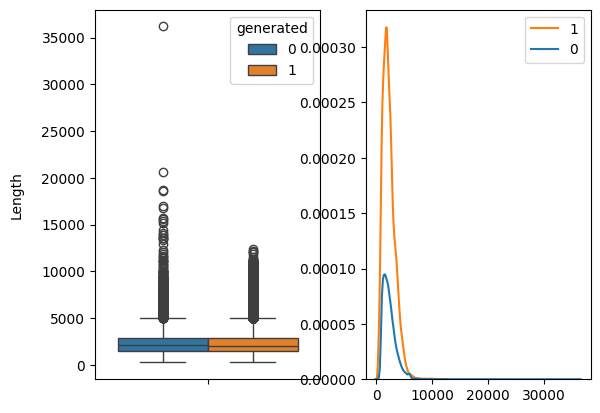

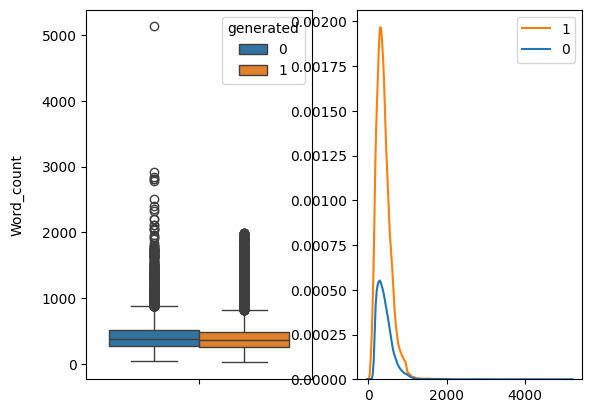

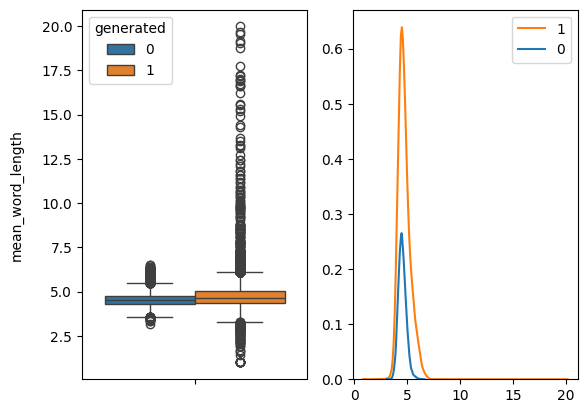

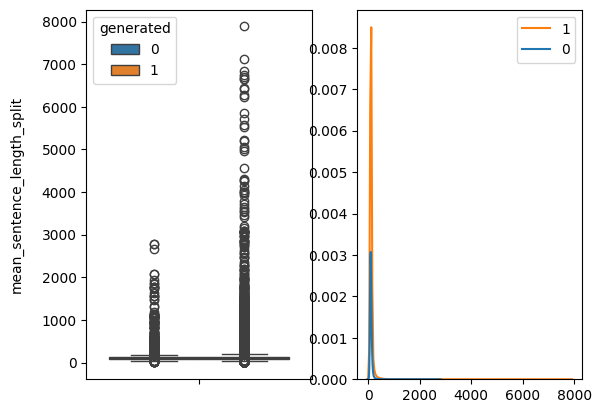

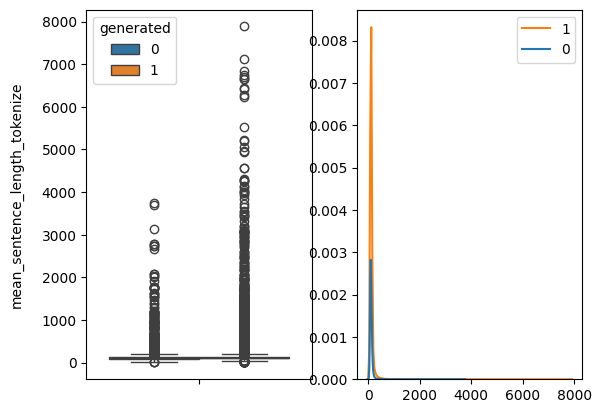

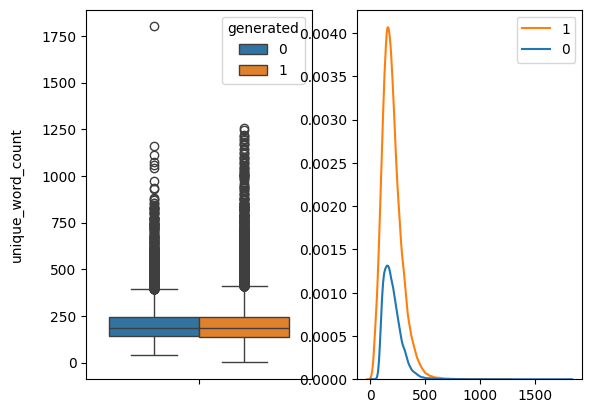

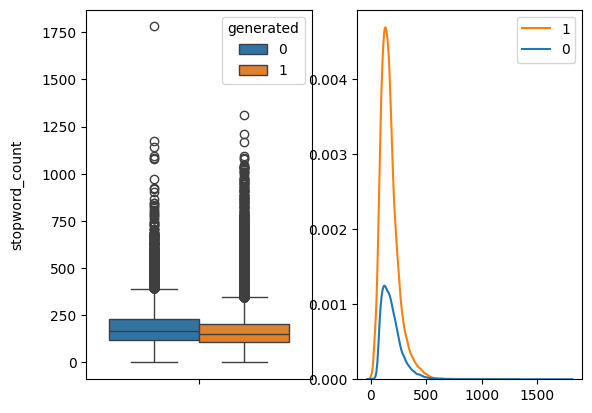

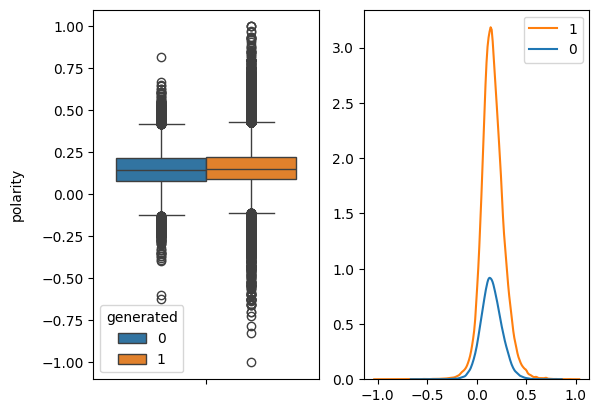

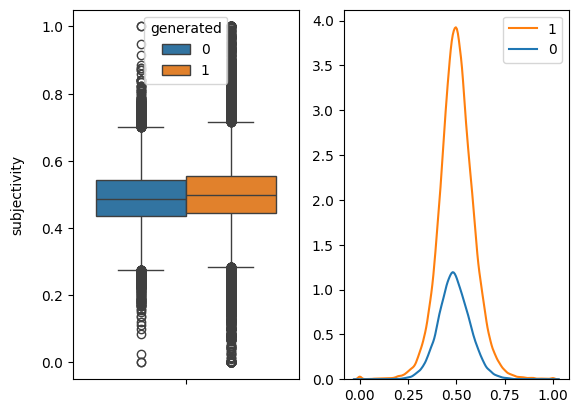

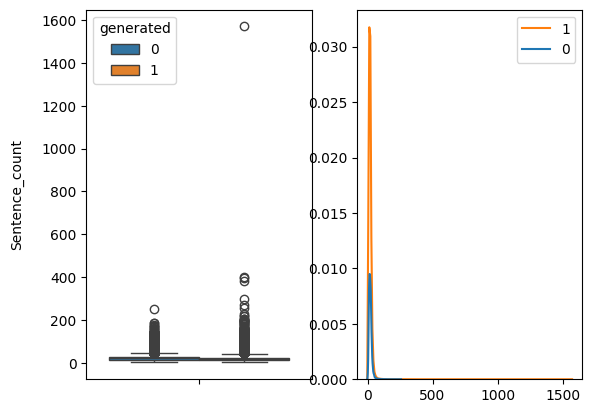

In [ ]:
for feature in features:
    visualize(text_df,feature,'generated')

## Feature Engineering

### V - Text Complexity Features

	•	Unique Word Count: The number of unique words in each text sample, capturing vocabulary richness.
	•	Stop Word Count: The number of common stop words (like “the”, “is”, “and”) that can indicate writing style.
	•	Readability Scores: Metrics like Flesch-Kincaid or Gunning Fog scores, which can give insights into text complexity.

In [ ]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

text_df['unique_word_count'] = text_df['text'].apply(lambda x: len(set(x.split())))
text_df['stopword_count'] = text_df['text'].apply(lambda x: len([word for word in x.split() if word in stop_words]))

### ! - NGRAMS -TF-IDF (Term Frequency-Inverse Document Frequency)

TF-IDF is a way to weight words based on how frequently they appear across documents, emphasizing unique words. This is often more effective than raw word counts for feature extraction.

In [ ]:
# Takes time
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=1000, ngram_range=(2, 6))
tfidf_features = tfidf.fit_transform(text_df['text'])

In [ ]:
tfidf_features

### V - Sentiment Analysis

Many libraries, like TextBlob or VADER, provide sentiment analysis, yielding features like polarity (positive/negative sentiment) and subjectivity.

In [ ]:
from textblob import TextBlob

text_df['polarity'] = text_df['text'].apply(lambda x: TextBlob(x).sentiment.polarity)
text_df['subjectivity'] = text_df['text'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

In [ ]:
text_df.head()

,id,prompt_id,text,generated,Character_Count,Word_count,Average_word_length,Sentence_count,Average_sentence_length_split,Average_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,20,84.238095,88.250000,174,139,0.270650,0.432759
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,19,174.000000,183.157895,320,251,0.135949,0.448521
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,8,169.461538,276.000000,272,158,0.131495,0.405460
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,25,61.160000,60.960000,158,104,0.077507,0.333694
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,17,98.562500,92.529412,166,153,0.247581,0.428763


In [ ]:
text_df.to_csv('./text_df_2024_11_25_NUM2.csv', index=False, escapechar='\\')

### X - Part-of-Speech (POS) Tagging

POS tagging can help identify patterns in language use, such as the frequency of nouns, verbs, or adjectives. This is useful for certain NLP tasks like author profiling or style analysis.

In [ ]:
def pos_counts(text):
    tokens = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(tokens)
    pos_counts = nltk.FreqDist(tag for _, tag in pos_tags)
    return pos_counts

text_df['pos_counts'] = text_df['text'].apply(pos_counts)

### X - Named Entity Recognition (NER)

NER identifies entities like people, places, and organizations, which can be informative for text classification. The spaCy library provides easy-to-use NER.

In [ ]:
import spacy
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    return [(ent.text, ent.label_) for ent in doc.ents]

text_df['entities'] = text_df['text'].apply(extract_entities)

### ! - Word Embeddings (e.g., Word2Vec, GloVe)

Pre-trained word embeddings capture semantic meaning. Averaging word embeddings in a sentence or using pooled embeddings (like BERT) can create dense, informative features.

In [ ]:
# Example using Word2Vec (use GloVe or FastText similarly)
from gensim.models import Word2Vec

# Tokenize text data
sentences = text_df['text'].apply(lambda x: x.split())
w2v_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1)

# Generate embedding for each document by averaging word embeddings
def average_embedding(text):
    words = text.split()
    return sum(w2v_model.wv[word] for word in words if word in w2v_model.wv) / len(words)

text_df['avg_word2vec'] = text_df['text'].apply(average_embedding)

### X - Topic Modeling (LDA or NMF)

Latent Dirichlet Allocation (LDA) and Non-negative Matrix Factorization (NMF) can identify topics in text, converting documents into a fixed number of topics.

In [ ]:
# 15m+
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(max_features=1000)
dtm = vectorizer.fit_transform(text_df['text'])

lda = LatentDirichletAllocation(n_components=5)
topic_matrix = lda.fit_transform(dtm)

In [ ]:
print(topic_matrix)

### ! - Bag-of-Words (BOW)

BOW is a basic yet powerful representation of text as sparse vectors. You can limit the vocabulary size to manage feature count, as shown previously.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

bow = CountVectorizer(max_features=1000, ngram_range=(2, 6))
bow_features = bow.fit_transform(text_df['text'])

In [ ]:
print(bow_features)

### V -Keyword Extraction

Extract key phrases or terms that capture the main topics or ideas in each text. Techniques like TF-IDF, RAKE (Rapid Automatic Keyword Extraction), or spaCy’s noun chunks can be used.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=10, stop_words="english")
keywords_matrix = tfidf.fit_transform(text_df['text'])
text_df['keywords'] = [tfidf.inverse_transform(doc) for doc in keywords_matrix]

In [ ]:
# from sklearn.feature_extraction.text import TfidfVectorizer

# # Initialize TfidfVectorizer with n-gram range
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(2, 3))  # Bigrams and Trigrams

# # Fit and transform the text data
# X_tfidf = tfidf_vectorizer.fit_transform(text_df['text'])

# # Create a DataFrame from the resulting matrix for easy viewing
# tfidf_ngram_features = pd.DataFrame(X_tfidf.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# print(tfidf_ngram_features)

KeyboardInterrupt: 

#### heatmap

In [ ]:
cols_to_drop = ['id', 'prompt_id', 'text']
corr_columns = text_df.columns.drop(cols_to_drop)
correlations = text_df[corr_columns].corr(numeric_only=True)

In [ ]:
dataplot = sns.heatmap(correlations, cmap="YlGnBu", annot=True)

# Model

In [ ]:
data = pd.read_csv('https://media.githubusercontent.com/media/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/text_df_2024_11_14.csv')
data.head()

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,pos_counts,keywords
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,84.238095,88.250000,174,139,0.270650,0.432759,<FreqDist with 28 samples and 367 outcomes>,"[array(['car', 'help', 'cars', 'make', 'time']..."
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,174.000000,183.157895,320,251,0.135949,0.448521,<FreqDist with 31 samples and 664 outcomes>,"[array(['help', 'cars', 'make', 'time', 'like'..."
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,169.461538,276.000000,272,158,0.131495,0.405460,<FreqDist with 36 samples and 437 outcomes>,"[array(['car', 'make', 'time', 'people'], dtyp..."
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,61.160000,60.960000,158,104,0.077507,0.333694,<FreqDist with 27 samples and 311 outcomes>,"[array(['car', 'cars', 'time', 'people', 'scho..."
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,98.562500,92.529412,166,153,0.247581,0.428763,<FreqDist with 30 samples and 336 outcomes>,"[array(['car', 'time', 'like', 'just', 'people..."


## class Model

In [ ]:
class Model:
    def __init__(self, model, X, y, scaler=None, test_size=0.2, random_state=42, wandb_project=None):
        self.model = model
        self.X = X
        self.y = y
        self.scaler = scaler
        self.test_size = test_size
        self.random_state = random_state
        self.history = {}

        # Splitting the data
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=self.test_size, random_state=self.random_state
        )

        # W&B initialization
        self.wandb_project = wandb_project
        self.run = None
        if self.wandb_project:
            self.run = wandb.init(project=self.wandb_project, config={"random_state": self.random_state})

    def _normalize(self):
        """Normalize the data if a scaler is provided."""
        if self.scaler:
            self.scaler = self.scaler.fit(self.X_train)
            self.X_train = self.scaler.transform(self.X_train)
            self.X_test = self.scaler.transform(self.X_test)

    def _train(self):
        """Train the model."""
        self.model.fit(self.X_train, self.y_train)
        self.history['model'] = str(self.model)

    def _evaluate(self):
        """Evaluate the model."""
        self.y_pred = self.model.predict(self.X_test)
        self.accuracy = accuracy_score(self.y_test, self.y_pred)
        self.report = classification_report(self.y_test, self.y_pred, output_dict=True)
        self.confusion = confusion_matrix(self.y_test, self.y_pred)

        if self.run:
            # Log metrics to W&B
            wandb.log({
                "accuracy": self.accuracy,
                "classification_report": self.report,
            })

            # Log confusion matrix as a heatmap
            wandb.log({
                "confusion_matrix": wandb.Image(self._create_confusion_matrix_figure())
            })

    def _create_confusion_matrix_figure(self):
        """Create a matplotlib figure for the confusion matrix."""
        plt.figure(figsize=(8, 6))
        sns.heatmap(self.confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
        plt.title(f'Confusion Matrix\nAccuracy: {self.accuracy:.2f}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.tight_layout()
        return plt

    def save_model(self, filepath="model.pkl"):
        """Save the trained model as a pickle file."""
        joblib.dump(self.model, filepath)
        print(f"Model saved to {filepath}")

        if self.run:
            # Upload the saved model to W&B
            wandb.save(filepath)

    def run(self):
        """Run the pipeline: Normalize, Train, Evaluate."""
        self._normalize()
        self._train()
        self._evaluate()

    def finalize(self):
        """Finish W&B run if initialized."""
        if self.run:
            self.run.finish()

    def get_data(self):
        """
        Return evaluation data.
        - Accuracy
        - Classification Report
        - Confusion Matrix
        """
        return {
            'accuracy': self.accuracy,
            'classification_report': self.report,
            'confusion_matrix': self.confusion,
        }


## class ModelManager

In [ ]:
class ModelManager:
    def __init__(self, models, X, y, scaler=None, test_size=0.2, random_state=42, wandb_project=None):
        self.models = models
        self.X = X
        self.y = y
        self.scaler = scaler
        self.test_size = test_size
        self.random_state = random_state
        self.results_df = None
        self.model_instances = []
        self.wandb_project = wandb_project

        if wandb_project:
            wandb.init(project=wandb_project)

    def run_all(self):
        """Train, evaluate, and collect results for all models."""
        results = []

        for name, model in self.models.items():
            # Create and run a Model instance
            model_instance = Model(model, self.X, self.y, scaler=self.scaler, test_size=self.test_size,
                                   random_state=self.random_state, wandb_project=self.wandb_project)
            model_instance.run()
            self.model_instances.append(model_instance)

            # Collect metrics
            results.append({
                'Model': name,
                'Accuracy': model_instance.accuracy,
                'Precision (Weighted)': model_instance.report['weighted avg']['precision'],
                'Recall (Weighted)': model_instance.report['weighted avg']['recall'],
                'F1-Score (Weighted)': model_instance.report['weighted avg']['f1-score']
            })

            # Save the model
            filepath = f"{name.replace(' ', '_').lower()}_model.pkl"
            model_instance.save_model(filepath)

        # Save results to a DataFrame
        self.results_df = pd.DataFrame(results)

        # Log comparison graph to W&B
        if self.wandb_project:
            self._log_comparison_to_wandb()

    def _log_comparison_to_wandb(self):
        """Log a comparison graph to W&B."""
        metrics = ['Accuracy', 'Precision (Weighted)', 'Recall (Weighted)', 'F1-Score (Weighted)']
        comparison_data = []

        for _, row in self.results_df.iterrows():
            for metric in metrics:
                comparison_data.append({"Model": row["Model"], "Metric": metric, "Score": row[metric]})

        wandb.log({
            "comparison_graph": wandb.plot.bar(
                pd.DataFrame(comparison_data),
                x="Metric",
                y="Score",
                title="Model Performance Comparison",
                keys="Model"
            )
        })


## models run

In [ ]:
# Load dataset
# from sklearn.datasets import load_iris
# data = load_iris()
# X, y = data.data, data.target

target_col = 'generated'
cols_to_drop = [target_col, 'prompt_id', 'id', 'text', 'pos_counts', 'keywords']
cols = data.columns.drop(cols_to_drop)
X = data[cols]
y = data[target_col]

# Models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=200),
    'Random Forest': RandomForestClassifier(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    'SVM': SVC(kernel='linear')
}

# Initialize ModelManager
manager = ModelManager(models, X, y, scaler=StandardScaler(), wandb_project="AI-Generated-Text-Detector-Project")

# Run all models
manager.run_all()

# Visualize the comparison
manager.visualize_comparison()

# Access the results DataFrame
# results = manager.get_results()
# print(results)

# # Access individual model instances
# instances = manager.get_model_instances()
# for instance in instances:
#     print(instance.get_data())


wandb: Currently logged in as: lironrevah. Use `wandb login --relogin` to force relogin


TypeError: 'Run' object is not callable

## results

In [ ]:
df_results

,Model,Accuracy,Precision (Weighted),Recall (Weighted),F1-Score (Weighted)
0,Logistic Regression,0.766923,0.621673,0.766923,0.668771
1,Random Forest,0.816292,0.801648,0.816292,0.791841
2,XGBoost,0.786569,0.757106,0.786569,0.750394
3,SVM,0.769449,0.592052,0.769449,0.669194


# Draft

הקוד מטה- האם זה משהו שרץ ונשמר?

In [ ]:
text = text_df['text'].values[0]  # Assuming 'text' column contains a single string per row.
# ngram_counts = nltk.collocations(text, n=2)  # Calculate frequency of bigrams (2-grams)
text

In [ ]:
tokens = nltk.word_tokenize(text)

# Generate bigrams, trigrams, and quadragrams
bigrams = list(ngrams(tokens, 2))
trigrams = list(ngrams(tokens, 3))
quadragrams = list(ngrams(tokens, 4))

# Count frequencies of each n-gram
bigram_freq = Counter(bigrams)
trigram_freq = Counter(trigrams)
quadragram_freq = Counter(quadragrams)

# Display results
print("Bigrams:", bigram_freq)
print("Trigrams:", trigram_freq)
print("Quadragrams:", quadragram_freq)

## CSV - Save or Read

In [ ]:
text_df.to_csv('./text_df_2024_11_14.csv', index=False, escapechar='\\')

In [ ]:
a=pd.read_csv('https://media.githubusercontent.com/media/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/text_df_2024_11_14.csv')
a.head()

,id,prompt_id,text,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity,pos_counts,keywords
0,e_ddxvqx5i,0,"In recent years, there has been a growing move...",1,1789,316,4.648734,84.238095,88.250000,174,139,0.270650,0.432759,<FreqDist with 28 samples and 367 outcomes>,"[array(['car', 'help', 'cars', 'make', 'time']..."
1,e_hi0yzrcv,0,---\nWhy not cars in our life\n===============...,1,3499,596,4.870805,174.000000,183.157895,320,251,0.135949,0.448521,<FreqDist with 31 samples and 664 outcomes>,"[array(['help', 'cars', 'make', 'time', 'like'..."
2,e_uesv4xha,0,A car is considered by many a nessecity for ev...,1,2215,392,4.647959,169.461538,276.000000,272,158,0.131495,0.405460,<FreqDist with 36 samples and 437 outcomes>,"[array(['car', 'make', 'time', 'people'], dtyp..."
3,e_2tl5ylwy,0,"H\n\nello fellow citezens , we are here to inf...",0,1553,308,4.025974,61.160000,60.960000,158,104,0.077507,0.333694,<FreqDist with 27 samples and 311 outcomes>,"[array(['car', 'cars', 'time', 'people', 'scho..."
4,e_s6ci4vj0,0,Have you ever known how if feels not being abl...,1,1592,314,4.063694,98.562500,92.529412,166,153,0.247581,0.428763,<FreqDist with 30 samples and 336 outcomes>,"[array(['car', 'time', 'like', 'just', 'people..."


In [ ]:
ngrams_df=pd.read_csv('https://media.githubusercontent.com/media/liron7722/AI-Generated-Text-Detector/refs/heads/Production/data/tfidf_ngram_features.csv')

In [ ]:
ngrams_df

,able to,about the,and it,and the,and they,are not,be able,be able to,because it,because they,...,venus is,want to,way to,we can,what they,will be,with the,would be,you are,you can
0,0.000000,0.0,0.000000,0.072423,0.095503,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.096555,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.438768
1,0.000000,0.0,0.225456,0.185795,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.194164,0.000000,0.0,0.0,0.219117,0.000000,0.181321,0.0,0.000000
2,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
3,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
4,0.119864,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.139952,0.144421,...,0.0,0.125307,0.000000,0.0,0.0,0.000000,0.000000,0.117019,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
158289,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.197696,0.000000,0.0,0.000000
158290,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.410897,0.000000,0.0,0.000000
158291,0.000000,0.0,0.000000,0.686151,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000
158292,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,...,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000


In [ ]:
ngrams_df.columns

Index(['able to', 'about the', 'and it', 'and the', 'and they', 'are not',
       'be able', 'be able to', 'because it', 'because they', 'believe that',
       'by the', 'can be', 'can help', 'car usage', 'community service',
       'could be', 'do not', 'driverless cars', 'electoral college', 'face on',
       'face on mars', 'for example', 'for the', 'from the', 'get to',
       'going to', 'have been', 'have to', 'if the', 'if they', 'if you',
       'in conclusion', 'in the', 'is not', 'is that', 'is the', 'it can',
       'it is', 'it was', 'it will', 'it would', 'lot of', 'need to', 'not be',
       'of the', 'on mars', 'on the', 'one of', 'should be', 'students to',
       'such as', 'that is', 'that it', 'that the', 'that they', 'that you',
       'the article', 'the author', 'the car', 'the electoral',
       'the electoral college', 'the face', 'the people', 'the president',
       'the same', 'the students', 'the world', 'their own', 'them to',
       'there are', 'there is'

## ?- CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Sample corpus
corpus = [
    "this is a sample text",
    "this is another example text",
    "ngram features are useful"
]

# Generate 2-grams and 3-grams
vectorizer = CountVectorizer(ngram_range=(2, 3))
X = vectorizer.fit_transform(corpus)

# Get n-gram feature names
feature_names = vectorizer.get_feature_names_out()

# Convert to dense matrix for easier readability
dense_matrix = X.toarray()

print("Feature Names:", feature_names)
print("N-Gram Matrix:\n", dense_matrix)

Feature Names: ['another example' 'another example text' 'are useful' 'example text'
 'features are' 'features are useful' 'is another' 'is another example'
 'is sample' 'is sample text' 'ngram features' 'ngram features are'
 'sample text' 'this is' 'this is another' 'this is sample']
N-Gram Matrix:
 [[0 0 0 0 0 0 0 0 1 1 0 0 1 1 0 1]
 [1 1 0 1 0 0 1 1 0 0 0 0 0 1 1 0]
 [0 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0]]


In [ ]:
from sklearn.model_selection import train_test_split

# Example: Assuming `labels` is your target variable
cols = a.columns
cols = cols.drop(['generated', 'prompt_id', 'id', 'text'])
X = a[cols]  # Sparse matrix from TfidfVectorizer
y = a['generated']  # Replace 'label' with your target column name

# Split the data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## ?-TruncatedSVD

In [ ]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=10)  # Reduce to 100 features
X_reduced_train = svd.fit_transform(X_train)
X_reduced_test = svd.transform(X_test)

ValueError: could not convert string to float: '<FreqDist with 26 samples and 565 outcomes>'

## ?-pipeline

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Create a pipeline with TfidfVectorizer and SVM
pipeline = Pipeline([
    ('tfidf', b),
    ('svm', SVC(kernel='linear'))
])

# Train the pipeline
pipeline.fit(a['text'], a['generated'])

# Make predictions
pipeline.predict(["This is a test sentence."])

ValueError: The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

## ? - GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'tfidf__max_features': [500, 1000],
    'svm__C': [0.1, 1, 10]
}

grid = GridSearchCV(pipeline, param_grid, cv=5)
grid.fit(a['text'], a['generated'])

print("Best Parameters:", grid.best_params_)

## Corr matrix

In [ ]:
a.corr(numeric_only=True)

,prompt_id,generated,Length,Word_count,mean_word_length,mean_sentence_length_split,mean_sentence_length_tokenize,unique_word_count,stopword_count,polarity,subjectivity
prompt_id,1.000000,-0.016817,0.250584,0.165469,0.028863,-0.013893,-0.005648,0.246865,0.038290,-0.155512,-0.080170
generated,-0.016817,1.000000,-0.024783,-0.053793,0.014047,0.044059,0.039380,-0.012095,-0.079310,0.046769,0.055007
Length,0.250584,-0.024783,1.000000,0.968029,0.031647,0.135309,0.137258,0.796943,0.860700,-0.069561,-0.064756
Word_count,0.165469,-0.053793,0.968029,1.000000,-0.000299,0.136332,0.109505,0.766971,0.939237,-0.047401,-0.057591
mean_word_length,0.028863,0.014047,0.031647,-0.000299,1.000000,0.082047,0.093121,0.012068,-0.016419,-0.013434,-0.024539
mean_sentence_length_split,-0.013893,0.044059,0.135309,0.136332,0.082047,1.000000,0.842447,0.048854,0.096024,-0.024057,-0.034350
mean_sentence_length_tokenize,-0.005648,0.039380,0.137258,0.109505,0.093121,0.842447,1.000000,0.044002,0.069000,-0.028303,-0.040009
unique_word_count,0.246865,-0.012095,0.796943,0.766971,0.012068,0.048854,0.044002,1.000000,0.617845,-0.153346,-0.099979
stopword_count,0.038290,-0.079310,0.860700,0.939237,-0.016419,0.096024,0.069000,0.617845,1.000000,0.008382,-0.007340
polarity,-0.155512,0.046769,-0.069561,-0.047401,-0.013434,-0.024057,-0.028303,-0.153346,0.008382,1.000000,0.229934
